In [2]:
%matplotlib notebook

import os
import time
import numpy as np
import matplotlib as mpl
import pandas as pd

from collections import OrderedDict
from importlib import reload
from matplotlib import pyplot as plt

In [3]:
import qcodes as qc
from qcodes import load_by_id
from qcodes.dataset.measurements import Measurement
from qcodes.instrument.base import Instrument
from qcodes.instrument.parameter import Parameter


In [4]:
from pytopo.qctools.instruments import create_inst
from pytopo.qctools.dataset2 import select_experiment

from plottr import client
from plottr.qcodes_dataset import QcodesDatasetSubscriber

from pytopo.mplplots.init_nb_plotting import *

qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments.db"

In [5]:
from scipy import constants
from scipy.interpolate import interp1d
from scipy.optimize import fmin
from scipy.integrate import cumtrapz
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [6]:
from qcodes.dataset.sqlite_base import transaction, one

def get_timestamp(run_id):
    DB = qc.config["core"]["db_location"]
    
    d = DataSet(DB)
    sql = """
    SELECT run_timestamp
    FROM
      runs
    WHERE
      run_id= ?
    """
    c = transaction(d.conn, sql, run_id)
    run_timestamp = one(c, 'run_timestamp')
    return run_timestamp

def timestamp_to_fmt(ts, fmt):
    return time.strftime(fmt, time.gmtime(ts))

def img_basepath(run_id):
    ts = get_timestamp(run_id)
    return timestamp_to_fmt(ts, qc.config['user']['img_dir'] + str(run_id).zfill(4) + '_')

def ds_title(run_id):
    return "{} #{}".format(os.path.abspath(qc.config['core']['db_location']), run_id)

qc.config['user']['img_dir'] = "d:/data/images/%Y-%m/%Y-%m-%d/"
qc.config.save_to_cwd()

In [7]:
dv = qc.load_by_id(406)
dv

results #406@d:/OneDrive/BF1/Data/experiments.db
------------------------------------------------
ivvi_setup_dac4 - numeric
ivvi_setup_i_measurement - numeric
ivvi_setup_ig_measurement - numeric
ivvi_setup_g_measurement - numeric

<IPython.core.display.Javascript object>


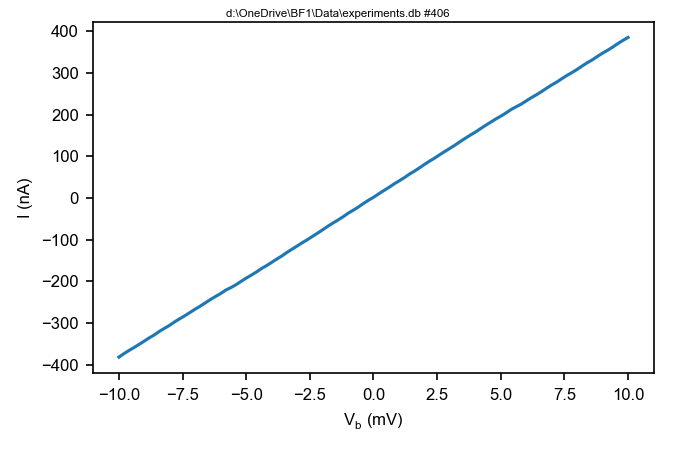

26116.3316606


In [8]:
Vbias = np.array(dv.get_data("ivvi_setup_dac4"))[:,0] 
i     = np.array(dv.get_values('ivvi_setup_i_measurement'))[:,0]
g     = np.array(dv.get_values('ivvi_setup_g_measurement'))[:,0]

fig, ax = plt.subplots(1,1)

ax.plot(Vbias*1e3, i*1e9)
ax.set_ylabel(r'I (nA)')
ax.set_xlabel(r"$\mathregular{V_b}$ (mV)")

R = (Vbias.max()-Vbias.min())/(i.max()-i.min())
print(R)


fig.suptitle(ds_title(str(dv.run_id)), size='x-small')
fig.tight_layout()

# Pinchoffs

<IPython.core.display.Javascript object>


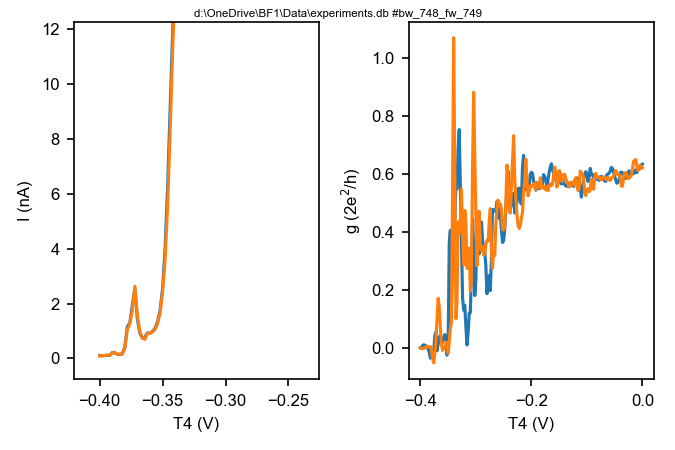

In [31]:
dv1 = qc.load_by_id(748)
dv2 = qc.load_by_id(749)

bg_fw = np.array(dv1.get_data("ivvi_setup_dac11"))[:,0] 
i_fw = np.array(dv1.get_values('ivvi_setup_i_measurement'))[:,0]
g_fw = np.array(dv1.get_values('ivvi_setup_g_measurement'))[:,0]

bg_bw = np.array(dv2.get_data("ivvi_setup_dac11"))[:,0] 
i_bw = np.array(dv2.get_values('ivvi_setup_i_measurement'))[:,0]
g_bw = np.array(dv2.get_values('ivvi_setup_g_measurement'))[:,0]

fig, (ax1, ax2) = plt.subplots(1,2)

tunnel_label  = "T4 (V)"

ax1.plot(bg_fw, i_fw*1e9)
ax1.plot(bg_bw, i_bw*1e9)
ax1.set_xlabel(tunnel_label)
ax1.set_ylabel('I (nA)')
# ax1.set_xlim([-0.3, -0.25])

ax2.plot(bg_fw, g_fw)
ax2.plot(bg_bw, g_bw)
ax2.set_xlabel(tunnel_label)
ax2.set_ylabel(r'g (2e$^2$/h)')
# ax2.set_xlim([-4, 0])
# ax2.set_ylim([0,4])

fig.suptitle(ds_title("bw_" + str(dv1.run_id) + "_fw_" + str(dv2.run_id)), size='x-small')
fig.tight_layout()

# Gap

<IPython.core.display.Javascript object>


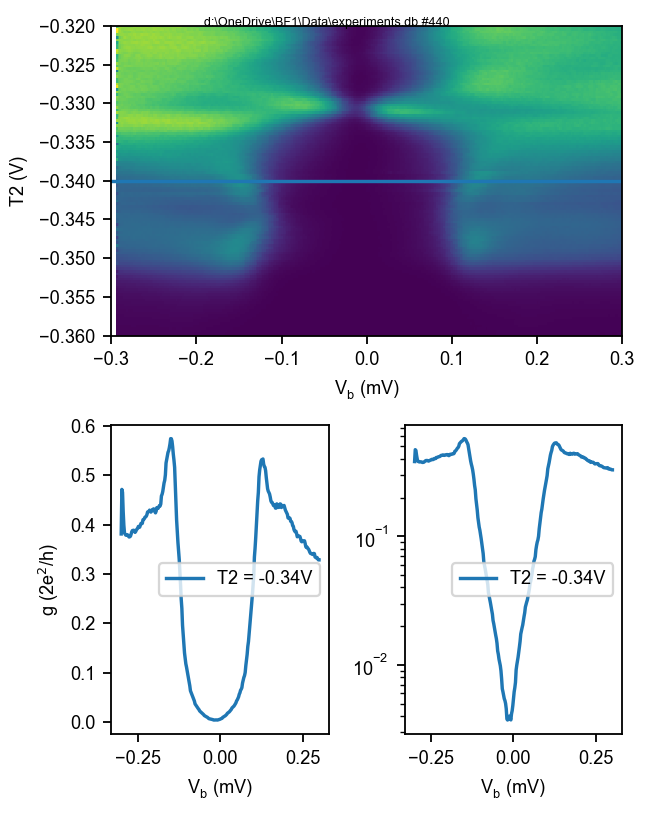

In [32]:
dv1 = qc.load_by_id(440)

bg = np.array(dv1.get_data("ivvi_setup_dac7"))[:,0] 
bias = np.array(dv1.get_data("ivvi_setup_dac4"))[:,0] 
i = np.array(dv1.get_values('ivvi_setup_i_measurement'))[:,0]
g = np.array(dv1.get_values('ivvi_setup_g_measurement'))[:,0]



bg = np.unique(bg)
bg = np.flip(bg, 0)
bias= np.unique(bias)

n_lines = bg.size

g = g.reshape(n_lines, bias.size)

fig = plt.figure(figsize=(4,5))

ax1 = plt.subplot(211)
ax2 = plt.subplot(223)
ax3 = plt.subplot(224)

bg_cut = -0.34
bg_cut_idx = np.argmin(abs(bg - bg_cut))
n_cut = 40

p = ax1.pcolor(bias[3::]*1e3, bg[0:n_lines], g[:,3::])
ax1.axhline(y=bg_cut)
ax1.set_ylabel(r"$\mathregular{T2}$ (V)")
ax1.set_xlabel(r"$\mathregular{V_b}$ (mV)")
ax1.set_xlim([-0.3,0.3])

ax2.plot(bias*1e3, g[bg_cut_idx,:], label='T2 = ' + str(bg_cut) + 'V')
ax2.set_ylabel(r'g (2e$^2$/h)')
ax2.set_xlabel(r"$\mathregular{V_b}$ (mV)")
ax2.legend(loc=0)
# ax2.text(0.2, 0.9, r"$\mathregular{\Delta = 250 \mu eV}$", horizontalalignment='center',  verticalalignment='top', transform=ax.transAxes)

ax3.semilogy(bias*1e3, g[bg_cut_idx,:], label='T2 = ' + str(bg_cut) + 'V')
ax3.set_xlabel(r"$\mathregular{V_b}$ (mV)")
ax3.legend(loc=0)

fig.suptitle(ds_title(str(dv1.run_id)), size='x-small')
fig.tight_layout()

# fig.savefig("d:/data/images/gap_dev14.png", dpi=300)

# gate vs gate

In [12]:
def data2d(x,y,z):
    x = np.unique(x)
    y = np.unique(y)
    if x[1]<x[0]:
        xc = np.flip(x, 0)
    else:
        xc = x
    if y[1]<y[0]:
        yc = np.flip(y, 0)
    else:
        yc = y
    zc = z.reshape(xc.size, yc.size)
    return xc, yc, zc 

In [13]:
dv1 = qc.load_by_id(559)

pg = np.array(dv1.get_data("ivvi_setup_dac6"))[:,0] 
bias = np.array(dv1.get_data("ivvi_setup_dac4"))[:,0] 
i = np.array(dv1.get_values('ivvi_setup_i_measurement'))[:,0]
g = np.array(dv1.get_values('ivvi_setup_g_measurement'))[:,0]

pg, bias, g = data2d(pg, bias, g)

fig, ax1 = plt.subplots(1,1)

p1 = ax1.pcolor(bias*1e3, pg*1e3, g, vmin=0,vmax=0.4)
ax1.set_xlabel("bias (mV)")
ax1.set_ylabel("R2 (mV)")
cbar = plt.colorbar(p1, ax=ax1)
cbar.set_label(r'g (2e$^2$/h)')

fig.suptitle(ds_title(str(dv1.run_id)), size='x-small')
fig.tight_layout()

ValueError: cannot reshape array of size 4037 into shape (40,101)

In [ ]:
dv1 = qc.load_by_id(516)

r2 = np.array(dv1.get_data("ivvi_setup_dac10"))[:,0] 
bias = np.array(dv1.get_data("ivvi_setup_dac4"))[:,0] 
i = np.array(dv1.get_values('ivvi_setup_i_measurement'))[:,0]
g = np.array(dv1.get_values('ivvi_setup_g_measurement'))[:,0]

r2, bias, g = data2d(r2, bias, g)

fig, ax1 = plt.subplots(1,1)

p1 = ax1.pcolor(bias*1e3, r2*1e3, g, vmin=0,vmax=0.4)
ax1.set_xlabel("bias (mV)")
ax1.set_ylabel("G (mV)")
cbar = plt.colorbar(p1, ax=ax1)
cbar.set_label(r'g (2e$^2$/h)')

fig.suptitle(ds_title(str(dv1.run_id)), size='x-small')
fig.tight_layout()


<IPython.core.display.Javascript object>


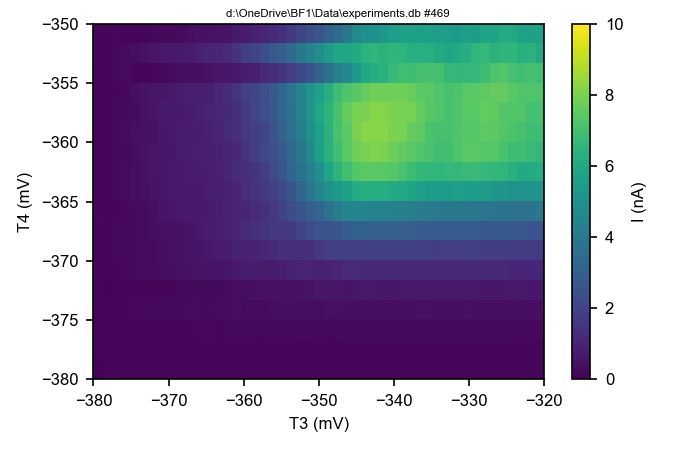

In [291]:
dv1 = qc.load_by_id(469)

pg = np.array(dv1.get_data("ivvi_setup_dac11"))[:,0] 
bias = np.array(dv1.get_data("ivvi_setup_dac8"))[:,0] 
i = np.array(dv1.get_values('ivvi_setup_i_measurement'))[:,0]
g = np.array(dv1.get_values('ivvi_setup_g_measurement'))[:,0]

pg, bias, i = data2d(pg, bias, i)

fig, ax1 = plt.subplots(1,1)

p1 = ax1.pcolor(bias*1e3, pg*1e3, i*1e9, vmin=0,vmax=10)
ax1.set_xlabel("T3 (mV)")
ax1.set_ylabel("T4 (mV)")
cbar = plt.colorbar(p1, ax=ax1)
cbar.set_label(r'I (nA)')

fig.suptitle(ds_title(str(dv1.run_id)), size='x-small')
fig.tight_layout()

<IPython.core.display.Javascript object>


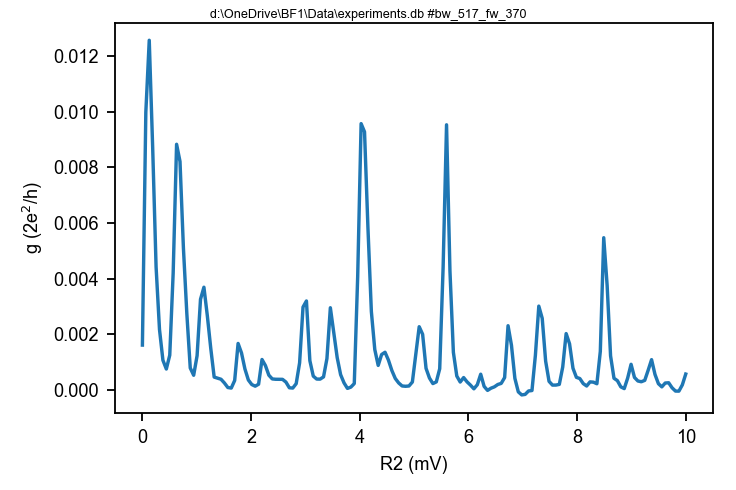

In [225]:
dv1 = qc.load_by_id(517)

pg = np.array(dv1.get_data("ivvi_setup_dac10"))[:,0] 
i = np.array(dv1.get_values('ivvi_setup_i_measurement'))[:,0]
g = np.array(dv1.get_values('ivvi_setup_g_measurement'))[:,0]



fig, (ax1) = plt.subplots(1,1)

ax1.plot(pg*1e3, g)
ax1.set_xlabel("R2 (mV)")
ax1.set_ylabel(r'g (2e$^2$/h)')

fig.suptitle(ds_title("bw_" + str(dv1.run_id) + "_fw_" + str(dv2.run_id)), size='x-small')
fig.tight_layout()

In [8]:
dv1 = qc.load_by_id(486)
dv1

results #486@d:/OneDrive/BF1/Data/experiments.db
------------------------------------------------
ivvi_setup_dac5 - numeric
ivvi_setup_dac6 - numeric
ivvi_setup_i_measurement - numeric
ivvi_setup_ig_measurement - numeric
ivvi_setup_g_measurement - numeric

<IPython.core.display.Javascript object>


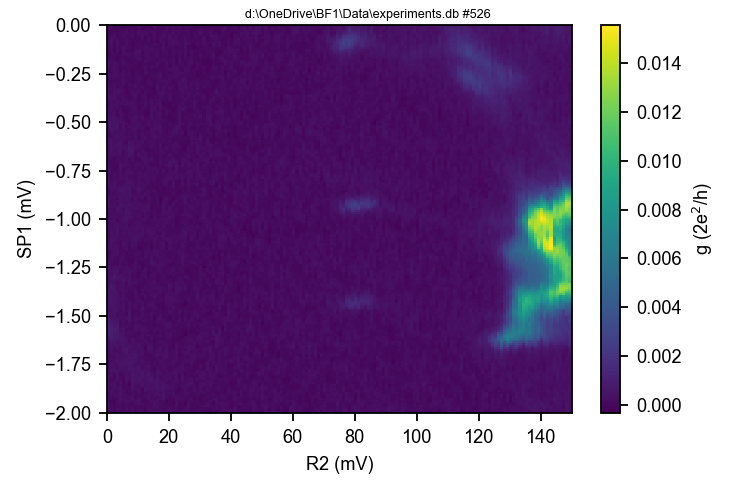

In [22]:
dv1 = qc.load_by_id(526)

sp1 = np.array(dv1.get_data("ivvi_setup_dac13"))[:,0] 
r2 = np.array(dv1.get_data("ivvi_setup_dac6"))[:,0] 
i = np.array(dv1.get_values('ivvi_setup_i_measurement'))[:,0]
g = np.array(dv1.get_values('ivvi_setup_g_measurement'))[:,0]

sp1,r2,g = data2d(sp1,r2,  g)

# sp1 = np.flip(sp1, 0)

fig, ax1 = plt.subplots(1,1)

p1 = ax1.pcolor(sp1*1e3,r2*1e3, np.transpose(g))
ax1.set_xlabel("R2 (mV)")
ax1.set_ylabel("SP1 (mV)")
cbar = plt.colorbar(p1, ax=ax1)
cbar.set_label(r'g (2e$^2$/h)')


fig.suptitle(ds_title(str(dv1.run_id)), size='x-small')
fig.tight_layout()


In [19]:
dv1 = qc.load_by_id(514)
dv1

results #514@d:/OneDrive/BF1/Data/experiments.db
------------------------------------------------
ivvi_setup_dac5 - numeric
AMI430_field - numeric
ivvi_setup_i_measurement - numeric
ivvi_setup_ig_measurement - numeric
ivvi_setup_g_measurement - numeric

<IPython.core.display.Javascript object>


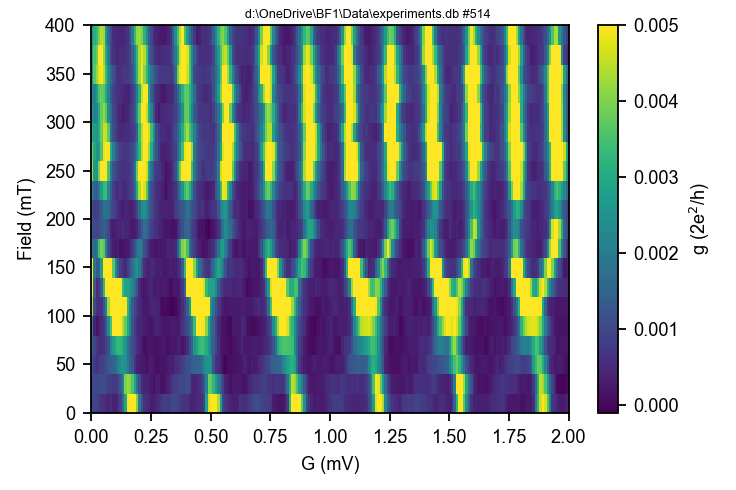

In [229]:
dv1 = qc.load_by_id(514)

pg = np.array(dv1.get_data("ivvi_setup_dac5"))[:,0] 
field = np.array(dv1.get_data("AMI430_field"))[:,0] 
i = np.array(dv1.get_values('ivvi_setup_i_measurement'))[:,0]
g = np.array(dv1.get_values('ivvi_setup_g_measurement'))[:,0]

pg = np.unique(pg)
field = np.unique(field)
# field = np.flip(field,0)
# pg, field, g = data2d(pg, field, g)
g = g.reshape(field.size, pg.size)

fig, ax1 = plt.subplots(1,1)

# ax1.plot(field)
p1 = ax1.pcolor(pg*1e3, field*1e3, g, vmax=.005)
ax1.set_ylabel("Field (mT)")
ax1.set_xlabel("G (mV)")
cbar = plt.colorbar(p1, ax=ax1)
cbar.set_label(r'g (2e$^2$/h)')

ax2.plot(pg, g[-1,:])

fig.suptitle(ds_title(str(dv1.run_id)), size='x-small')
fig.tight_layout()

In [111]:
from peakutils import peakutils

ModuleNotFoundError: No module named 'peakdetect'

In [184]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

<IPython.core.display.Javascript object>


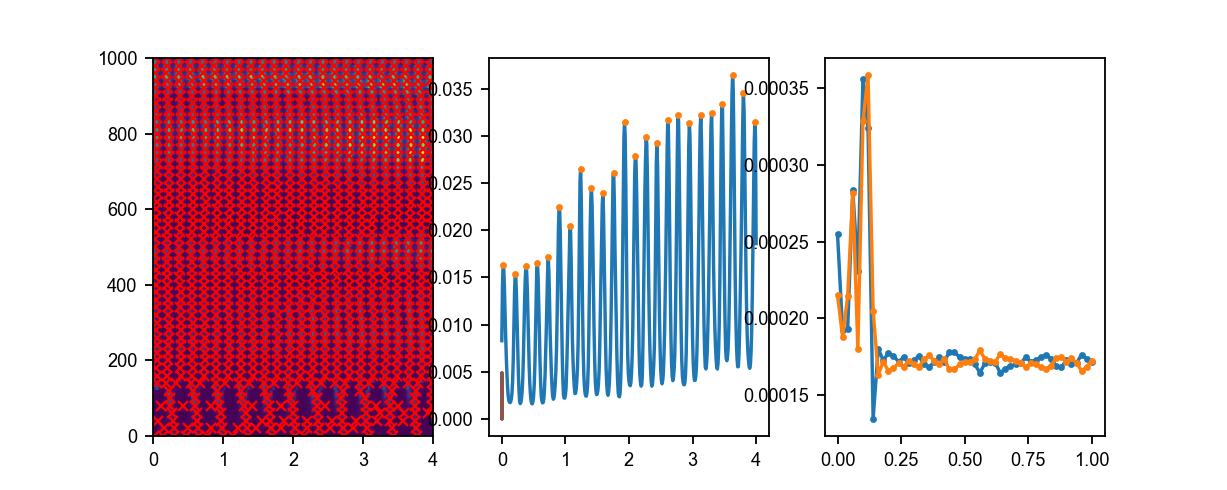

In [224]:
dv1 = qc.load_by_id(515)

pg = np.array(dv1.get_data("ivvi_setup_dac5"))[:,0] 
field = np.array(dv1.get_data("AMI430_field"))[:,0] 
i = np.array(dv1.get_values('ivvi_setup_i_measurement'))[:,0]
g = np.array(dv1.get_values('ivvi_setup_g_measurement'))[:,0]

pg = np.unique(pg)
field = np.unique(field)
field = np.flip(field,0)
# pg, field, g = data2d(pg, field, g)
g = g.reshape(field.size, pg.size)

Nsmooth_x = 3 #1 = no smoothing
Nsmooth_y = 1
#pd.rolling_mean(x, N)[N-1:]

g_smooth = np.ones(np.shape(g))
for i in range(field.size):
    g_smooth[i,:] = smooth(g[i,:], Nsmooth_x)
    
g_smoothy = np.ones(np.shape(g))
for i in range(pg.size):
    g_smoothy[:,i] = smooth(g_smooth[:,i], Nsmooth_y)

g = g_smoothy
    
    
q = []
for i in range(field.size):
    if field[i]<0.150:
        q.append(peakutils.indexes(g[i,:], thres=0.08, min_dist=10))
    else:
        q.append(peakutils.indexes(g[i,:], thres=0.08, min_dist=10))
        

q

idx=4
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(7.5,3))

ax2.plot(pg*1e3, g[idx,:])
ax2.plot(pg[q[idx]]*1e3, g[idx,q[idx]], ".")

for idx in range(field.size):
    ax1.plot(pg[q[idx]]*1e3, field[idx]*1e3*np.ones(q[idx].size), 'x', color='red')

ax1.pcolor(pg*1e3, field*1e3, g)



even = []
odd = []
for i in range(field.size):
    w = np.array(pg[q[i]])
    z = w[1::] - w[0:-1]
    even.append(np.average(z[::2]))
    odd.append(np.average(z[1::2]))
    
ax3.plot(field, odd,'.-')
ax3.plot(field, even,'.-')
# ax3.plot(field, np.array(even)+np.array(odd),'.-')

[ 0.00016  0.00019  0.00015  0.00019  0.00017  0.00017  0.00017  0.00017
  0.00018  0.00017  0.00017] [ 0.00016  0.00015  0.00017  0.00017  0.00018  0.00017] [ 0.00019  0.00019  0.00017  0.00017  0.00017]


<IPython.core.display.Javascript object>


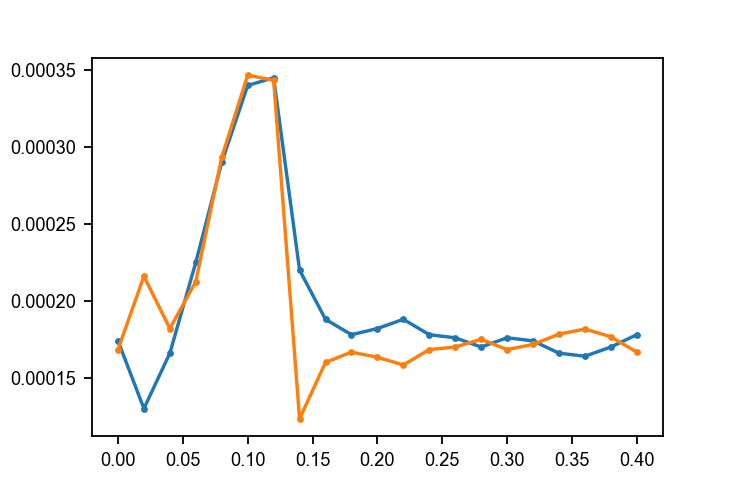

In [158]:
even = []
odd = []
for i in range(field.size):
    w = np.array(pg[q[i]])
    z = w[1::] - w[0:-1]
    even.append(np.average(z[::2]))
    odd.append(np.average(z[1::2]))

print(z, z[::2], z[1::2])
    
fig, ax1 = plt.subplots(1,1)
ax1.plot(field, odd,'.-')
ax1.plot(field, even,'.-')


In [82]:
z[1::2]

array([ 0.00018,  0.00018,  0.00017,  0.00017,  0.00017,  0.00017])

In [ ]:
def data2d(x,y,z):
    x = np.unique(x)
    y = np.unique(y)
    if x[1]>x[0]:
        xc = np.flip(x, 0)
    else:
        xc = x
    if y[1]>y[0]:
        yc = np.flip(y, 0)
    else:
        yc = y
    zc = z.reshape(xc.size, yc.size)
    return xc, yc, zc 